In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations
from scipy.optimize import linprog

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['font.size'] = 12
plt.rcParams['text.usetex'] = False  # Disable LaTeX, use mathtext instead
plt.rcParams['font.family'] = 'serif'  # Use serif font to look more like LaTeX
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern font for math

In [2]:
def create_clean_kuhn_tree():
    """
    Create a clean Kuhn Poker game tree with minimal text and clear structure.
    """
    G = nx.DiGraph()
    
    # Root chance node
    G.add_node("ROOT", type="chance", label="Chance")
    
    # All 6 possible card deals
    deals = [('K', 'Q'), ('K', 'J'), ('Q', 'K'), ('Q', 'J'), ('J', 'K'), ('J', 'Q')]
    
    for i, (p1_card, p2_card) in enumerate(deals):
        # Player 1's decision - connect directly from chance
        p1_node = f"P1_{p1_card}{p2_card}"
        G.add_node(p1_node, type="player1", label="P1")
        G.add_edge("ROOT", p1_node, label=f"{p1_card},{p2_card}")
        
        # P1 Passes
        p1_pass = f"P1P_{p1_card}{p2_card}"
        G.add_node(p1_pass, type="player2", label="P2")
        G.add_edge(p1_node, p1_pass, label="P")
        
        # P1 Bets
        p1_bet = f"P1B_{p1_card}{p2_card}"
        G.add_node(p1_bet, type="player2", label="P2")
        G.add_edge(p1_node, p1_bet, label="B")
        
        # Terminal nodes from P1 Pass
        # P1P, P2P - Showdown
        pp_payoff = 1 if p1_card > p2_card else -1
        pp_node = f"PP_{p1_card}{p2_card}"
        G.add_node(pp_node, type="terminal", label=f"{pp_payoff}")
        G.add_edge(p1_pass, pp_node, label="P")
        
        # P1P, P2B - P1 decides again
        pb_node = f"PB_{p1_card}{p2_card}"
        G.add_node(pb_node, type="player1", label="P1")
        G.add_edge(p1_pass, pb_node, label="B")
        
        # From P1P, P2B
        # P1 Folds
        pbf_node = f"PBF_{p1_card}{p2_card}"
        G.add_node(pbf_node, type="terminal", label="-1")
        G.add_edge(pb_node, pbf_node, label="F")
        
        # P1 Calls
        pbc_payoff = 2 if p1_card > p2_card else -2
        pbc_node = f"PBC_{p1_card}{p2_card}"
        G.add_node(pbc_node, type="terminal", label=f"{pbc_payoff}")
        G.add_edge(pb_node, pbc_node, label="C")
        
        # Terminal nodes from P1 Bet
        # P2 Folds
        bf_node = f"BF_{p1_card}{p2_card}"
        G.add_node(bf_node, type="terminal", label="1")
        G.add_edge(p1_bet, bf_node, label="F")
        
        # P2 Calls
        bc_payoff = 2 if p1_card > p2_card else -2
        bc_node = f"BC_{p1_card}{p2_card}"
        G.add_node(bc_node, type="terminal", label=f"{bc_payoff}")
        G.add_edge(p1_bet, bc_node, label="C")
    
    return G

In [3]:
def plot_clean_kuhn_tree(G, title=None):
    """
    Plot clean Kuhn Poker tree with color-coded nodes and minimal text.
    """
    plt.figure(figsize=(24, 10))  # Wider and shorter
    
    # Create hierarchical layout
    levels = {}
    for node in G.nodes():
        if node == "ROOT":
            levels[node] = 0
        elif node.startswith("P1_") and len(node.split("_")[1]) == 2:
            levels[node] = 1
        elif node.startswith("P1P_") or node.startswith("P1B_"):
            levels[node] = 2
        elif node.startswith("PB_"):
            levels[node] = 3
        else:  # Terminal nodes
            levels[node] = 4
    
    # Manual positioning for better layout - compress vertically, expand horizontally
    pos = {}
    level_width = {0: 1, 1: 8, 2: 12, 3: 6, 4: 18}  # Wider spread
    level_nodes = {i: [n for n, l in levels.items() if l == i] for i in range(5)}
    
    for level, nodes in level_nodes.items():
        y = 3 - level * 0.75  # Compressed vertical spacing
        if len(nodes) == 1:
            pos[nodes[0]] = (0, y)
        else:
            x_positions = np.linspace(-level_width[level], level_width[level], len(nodes))
            for i, node in enumerate(nodes):
                pos[node] = (x_positions[i], y)
    
    # Define colors for node types - larger nodes
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        node_type = G.nodes[node].get('type', 'unknown')
        if node_type == 'chance':
            node_colors.append('#FFD700')  # Gold
            node_sizes.append(2000)  # Larger
        elif node_type == 'player1':
            node_colors.append('#87CEEB')  # Sky blue
            node_sizes.append(1800)  # Larger
        elif node_type == 'player2':
            node_colors.append('#FFA07A')  # Light salmon
            node_sizes.append(1800)  # Larger
        elif node_type == 'terminal':
            node_colors.append('#98FB98')  # Pale green
            node_sizes.append(1500)  # Larger
        else:
            node_colors.append('gray')
            node_sizes.append(1200)
    
    # Draw the graph with shorter arrows
    nx.draw(G, pos,
            node_color=node_colors,
            node_size=node_sizes,
            with_labels=False,
            arrows=True,
            edge_color='black',
            width=2,
            arrowsize=15,  # Smaller arrows
            arrowstyle='->')
    
    # Add node labels
    labels = {node: G.nodes[node].get('label', node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=16, font_weight='bold')  # Larger font
    
    # Add edge labels
    edge_labels = {edge: G.edges[edge].get('label', '') for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=14, font_weight='bold')  # Larger font
    
    # Add node type legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFD700', markersize=18, label='Chance'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#87CEEB', markersize=18, label='Player 1'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFA07A', markersize=18, label='Player 2'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#98FB98', markersize=18, label='Payoff')
    ]
    legend1 = plt.legend(handles=legend_elements, loc='upper left', fontsize=14, title='Node Types', title_fontsize=16)
    plt.gca().add_artist(legend1)  # Keep first legend when adding second
    
    # Add action legend
    action_legend = [
        plt.Line2D([0], [0], color='black', label='P = Pass'),
        plt.Line2D([0], [0], color='black', label='B = Bet'),
        plt.Line2D([0], [0], color='black', label='F = Fold'),
        plt.Line2D([0], [0], color='black', label='C = Call')
    ]
    plt.legend(handles=action_legend, loc='upper right', fontsize=14, title='Actions', title_fontsize=16)
    
    # No title displayed
    plt.axis('off')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_13930/3461012399.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


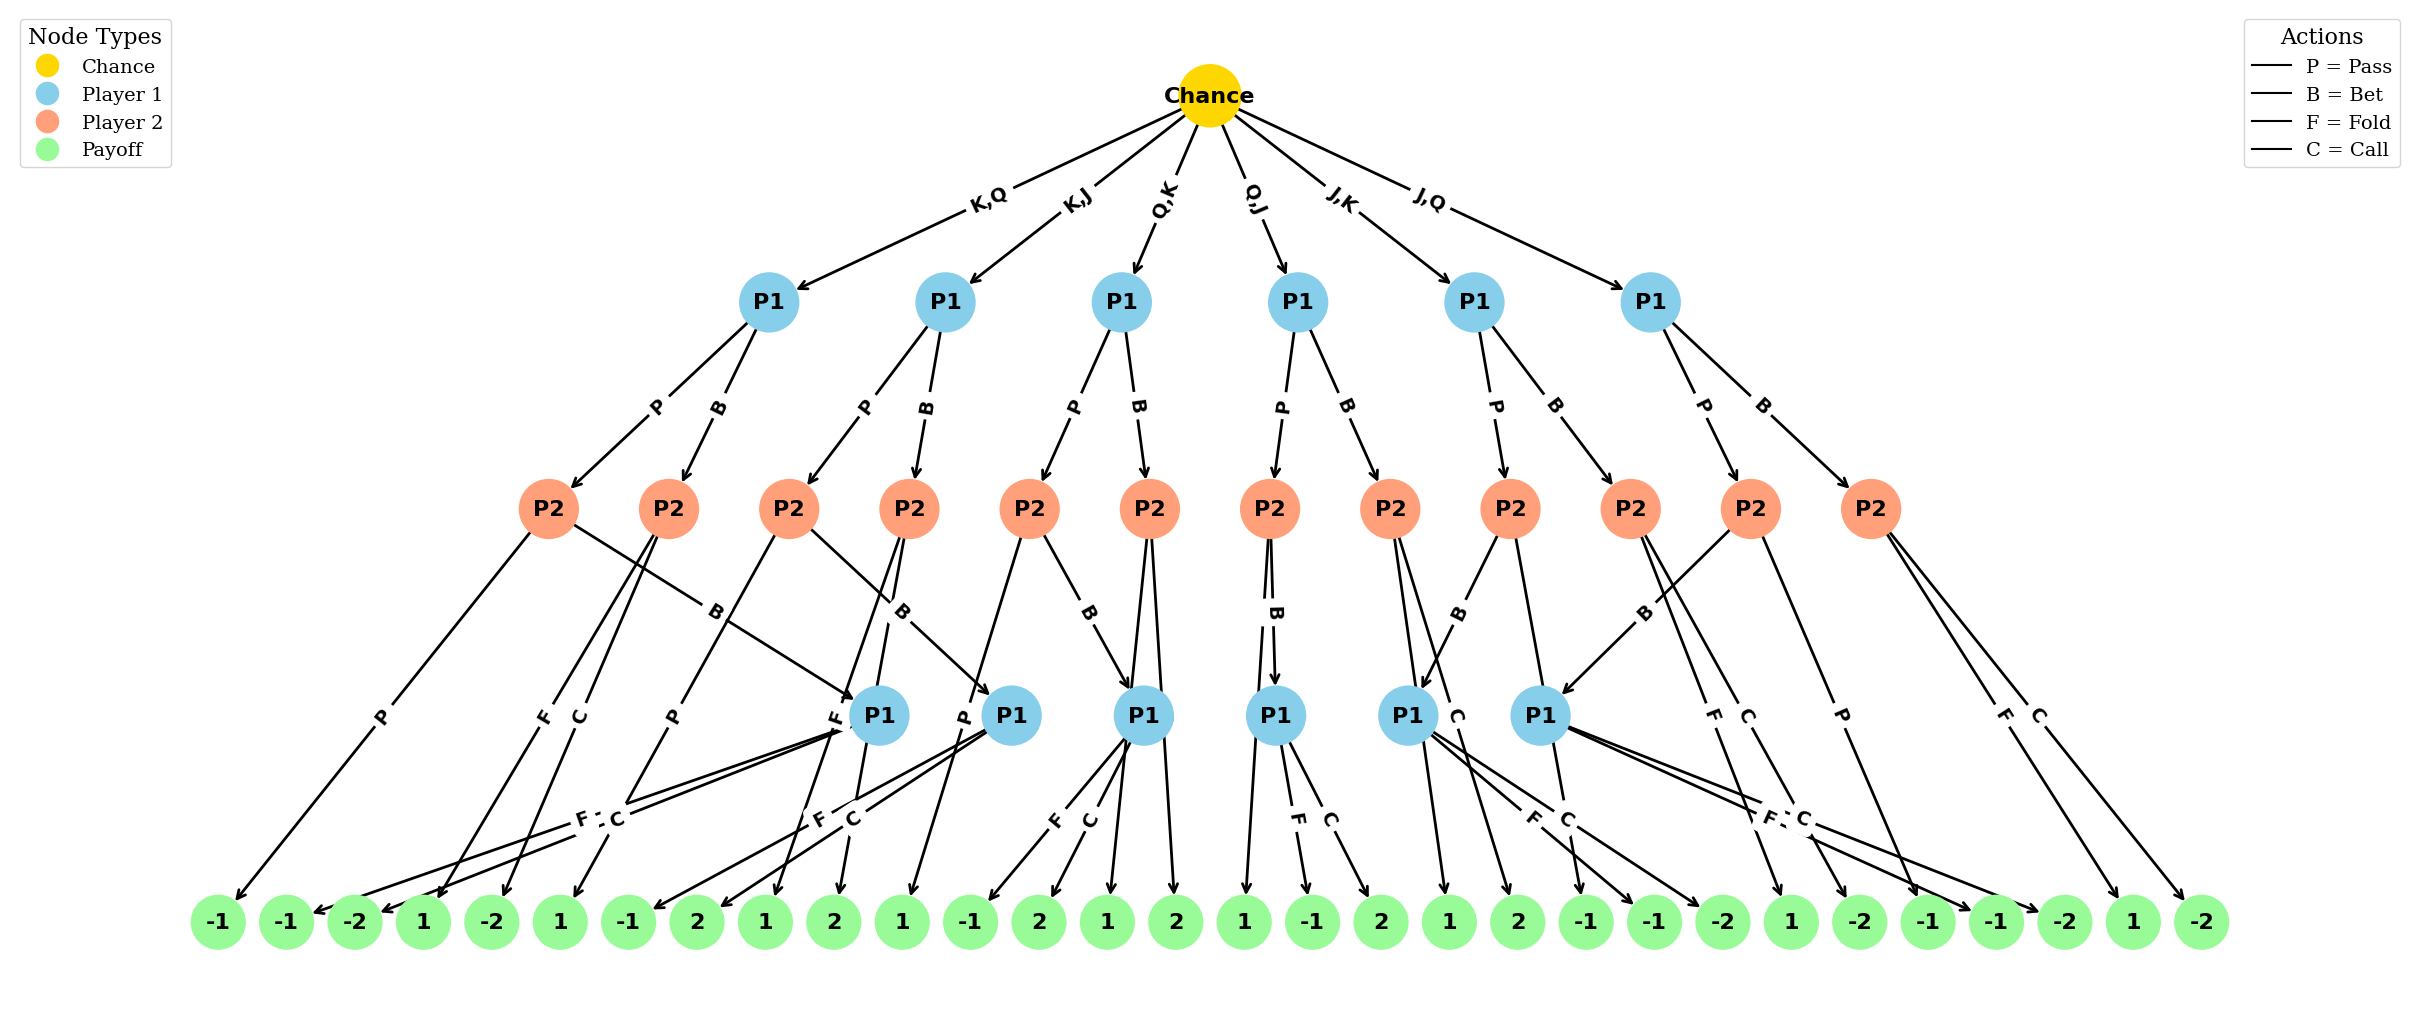

In [4]:
# Create and plot the clean Kuhn Poker game tree
clean_kuhn_tree = create_clean_kuhn_tree()
plot_clean_kuhn_tree(clean_kuhn_tree)

# Kuhn Poker Game Tree Analysis

## Game Description
Kuhn Poker is a simplified poker variant with:
- **2 players**, **3 cards** (J < Q < K)
- Each player gets 1 card, antes 1 chip
- **Actions**: Pass (P), Bet (B), Fold (F), Call (C)
- **Payoffs**: Winner takes pot (1 or 2 chips per player)

## Tree Structure
- **Gold nodes**: Chance (Nature) - card dealing
- **Blue nodes**: Player 1 decisions  
- **Salmon nodes**: Player 2 decisions
- **Green nodes**: Terminal payoffs (from Player 1's perspective)

The tree shows imperfect information through identical decision nodes for different opponent cards.

# Linear Programming Example: Factory Production Problem

This section demonstrates a practical linear programming problem involving production optimization in a factory that produces soda and juice.

In [6]:
# Define problem parameters
W = 90  # Water constraint
E = 80   # Energy constraint  
L = 60   # Labor constraint - made more restrictive

# Production costs
E_s = 0.6  # Energy cost per unit of soda
E_j = 1.0  # Energy cost per unit of juice
L_s = 0.8  # Labor cost per unit of soda
L_j = 0.5  # Labor cost per unit of juice

# Selling prices (profit per unit)
S_s = 3.0  # Selling price per unit of soda
S_j = 4.0  # Selling price per unit of juice

print("Problem Parameters:")
print(f"Water available: {W} units")
print(f"Energy budget: {E} units")
print(f"Labor budget: {L} units")
print(f"Soda: Energy cost = {E_s}, Labor cost = {L_s}, Selling price = {S_s}")
print(f"Juice: Energy cost = {E_j}, Labor cost = {L_j}, Selling price = {S_j}")

Problem Parameters:
Water available: 90 units
Energy budget: 80 units
Labor budget: 60 units
Soda: Energy cost = 0.6, Labor cost = 0.8, Selling price = 3.0
Juice: Energy cost = 1.0, Labor cost = 0.5, Selling price = 4.0


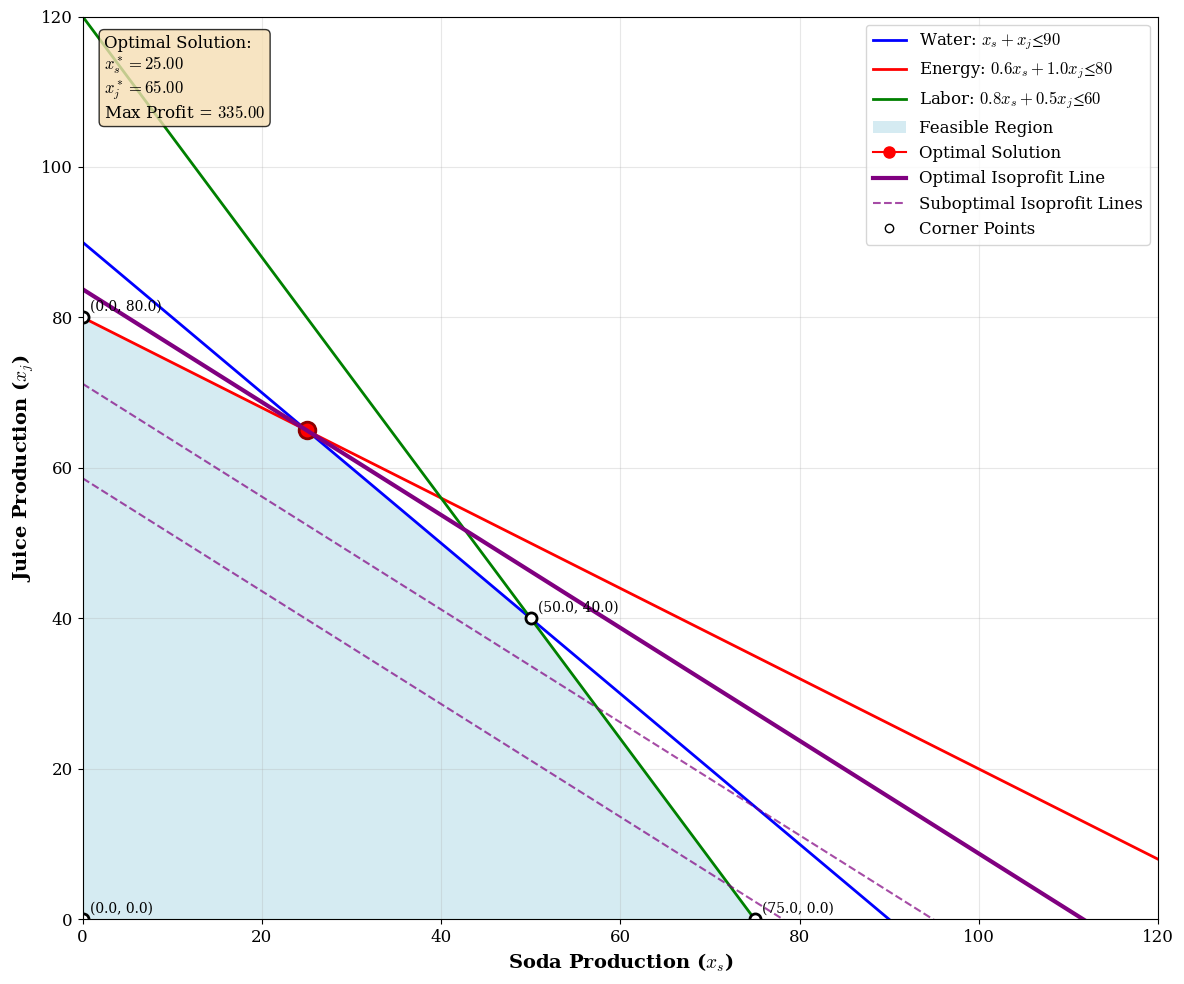


Optimal Solution:
Soda production (x_s): 25.00 units
Juice production (x_j): 65.00 units
Maximum profit: $335.00

Constraint Analysis:
Water usage: 90.00/90 (BINDING)
Energy usage: 80.00/80 (BINDING)
Labor usage: 52.50/60 (slack)


In [7]:
def plot_lp_problem():
    """
    Plot the graphical solution of the LP problem.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Define the range for plotting
    x_s = np.linspace(0, 120, 400)
    
    # Constraint lines
    # Water constraint: x_s + x_j <= W  =>  x_j <= W - x_s
    water_line = W - x_s
    
    # Energy constraint: E_s*x_s + E_j*x_j <= E  =>  x_j <= (E - E_s*x_s)/E_j
    energy_line = (E - E_s * x_s) / E_j
    
    # Labor constraint: L_s*x_s + L_j*x_j <= L  =>  x_j <= (L - L_s * x_s) / L_j
    labor_line = (L - L_s * x_s) / L_j
    
    # Plot constraint lines
    ax.plot(x_s, water_line, 'b-', linewidth=2, label=f'Water: $x_s + x_j ≤ {W}$')
    ax.plot(x_s, energy_line, 'r-', linewidth=2, label=f'Energy: ${E_s}x_s + {E_j}x_j ≤ {E}$')
    ax.plot(x_s, labor_line, 'g-', linewidth=2, label=f'Labor: ${L_s}x_s + {L_j}x_j ≤ {L}$')
    
    # Fill feasible region - make more visible
    x_fill = np.linspace(0, 120, 400)
    y_fill = np.minimum(np.minimum(W - x_fill, (E - E_s * x_fill) / E_j), (L - L_s * x_fill) / L_j)
    y_fill = np.maximum(y_fill, 0)  # Ensure non-negative
    
    ax.fill_between(x_fill, 0, y_fill, where=(y_fill >= 0), alpha=0.5, color='lightblue', label='Feasible Region')
    
    # Find optimal solution using scipy
    # Minimize negative profit (to maximize profit)
    c = [-S_s, -S_j]  # Coefficients for minimization
    A_ub = [[1, 1],           # Water constraint
            [E_s, E_j],       # Energy constraint
            [L_s, L_j]]       # Labor constraint
    b_ub = [W, E, L]
    bounds = [(0, None), (0, None)]  # Non-negativity constraints
    
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    
    if result.success:
        optimal_x_s, optimal_x_j = result.x
        optimal_profit = -result.fun
        
        # Plot optimal point
        ax.plot(optimal_x_s, optimal_x_j, 'ro', markersize=12, markerfacecolor='red', 
                markeredgecolor='darkred', markeredgewidth=2, label=f'Optimal Solution\n($x_s$={optimal_x_s:.1f}, $x_j$={optimal_x_j:.1f})')
        
        # Add objective function lines (isoprofit lines)
        for profit_level in [optimal_profit * 0.7, optimal_profit * 0.85, optimal_profit]:
            if profit_level > 0:
                # S_s*x_s + S_j*x_j = profit_level  =>  x_j = (profit_level - S_s*x_s)/S_j
                obj_line = (profit_level - S_s * x_s) / S_j
                line_style = '--' if profit_level < optimal_profit else '-'
                line_width = 3 if profit_level == optimal_profit else 1.5
                alpha = 1.0 if profit_level == optimal_profit else 0.7
                ax.plot(x_s, obj_line, 'purple', linestyle=line_style, linewidth=line_width, 
                       alpha=alpha, label=f'Profit = {profit_level:.1f}' if profit_level == optimal_profit else '')
    
    # Find and plot corner points of feasible region
    corner_points = []
    
    # Intersection of constraints
    intersections = [
        (0, 0),  # Origin
        (W, 0),  # Water constraint with x-axis
        (0, W),  # Water constraint with y-axis
        (E/E_s, 0),  # Energy constraint with x-axis
        (0, E/E_j),  # Energy constraint with y-axis
        (L/L_s, 0),  # Labor constraint with x-axis
        (0, L/L_j),  # Labor constraint with y-axis
    ]
    
    # Water-Energy intersection: x_s + x_j = W and E_s*x_s + E_j*x_j = E
    if E_j != 1:
        x_s_we = (E - E_j*W) / (E_s - E_j)
        x_j_we = W - x_s_we
        if x_s_we >= 0 and x_j_we >= 0:
            intersections.append((x_s_we, x_j_we))
    
    # Water-Labor intersection: x_s + x_j = W and L_s*x_s + L_j*x_j = L
    if L_j != 1:
        x_s_wl = (L - L_j*W) / (L_s - L_j)
        x_j_wl = W - x_s_wl
        if x_s_wl >= 0 and x_j_wl >= 0:
            intersections.append((x_s_wl, x_j_wl))
    
    # Energy-Labor intersection: E_s*x_s + E_j*x_j = E and L_s*x_s + L_j*x_j = L
    det = E_s*L_j - E_j*L_s
    if abs(det) > 1e-10:
        x_s_el = (E*L_j - L*E_j) / det
        x_j_el = (L*E_s - E*L_s) / det
        if x_s_el >= 0 and x_j_el >= 0:
            intersections.append((x_s_el, x_j_el))
    
    # Filter feasible corner points
    for x_s_pt, x_j_pt in intersections:
        if (x_s_pt >= 0 and x_j_pt >= 0 and 
            x_s_pt + x_j_pt <= W + 1e-10 and
            E_s*x_s_pt + E_j*x_j_pt <= E + 1e-10 and
            L_s*x_s_pt + L_j*x_j_pt <= L + 1e-10):
            corner_points.append((x_s_pt, x_j_pt))
    
    # Remove duplicates
    corner_points = list(set([(round(x, 6), round(y, 6)) for x, y in corner_points]))
    
    # Plot corner points
    for i, (x_s_pt, x_j_pt) in enumerate(corner_points):
        ax.plot(x_s_pt, x_j_pt, 'ko', markersize=8, markerfacecolor='white', 
                markeredgecolor='black', markeredgewidth=2)
        ax.annotate(f'({x_s_pt:.1f}, {x_j_pt:.1f})', 
                   (x_s_pt, x_j_pt), xytext=(5, 5), textcoords='offset points',
                   fontsize=10, ha='left')
    
    # Formatting
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 120)
    ax.set_xlabel('Soda Production ($x_s$)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Juice Production ($x_j$)', fontsize=14, fontweight='bold')
    # Remove title
    ax.grid(True, alpha=0.3)
    
    # Create custom legend with dotted lines for isoprofit
    legend_elements = [
        plt.Line2D([0], [0], color='b', linewidth=2, label=f'Water: $x_s + x_j ≤ {W}$'),
        plt.Line2D([0], [0], color='r', linewidth=2, label=f'Energy: ${E_s}x_s + {E_j}x_j ≤ {E}$'),
        plt.Line2D([0], [0], color='g', linewidth=2, label=f'Labor: ${L_s}x_s + {L_j}x_j ≤ {L}$'),
        plt.Rectangle((0,0),1,1, facecolor='lightblue', alpha=0.5, label='Feasible Region'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Optimal Solution'),
        plt.Line2D([0], [0], color='purple', linewidth=3, label='Optimal Isoprofit Line'),
        plt.Line2D([0], [0], color='purple', linewidth=1.5, linestyle='--', alpha=0.7, label='Suboptimal Isoprofit Lines'),
        plt.Line2D([0], [0], color='black', marker='o', markersize=6, markerfacecolor='white', 
                   markeredgecolor='black', linestyle='None', label='Corner Points')
    ]
    ax.legend(handles=legend_elements, fontsize=12, loc='upper right')
    
    # Add text box with solution
    if result.success:
        textstr = f'Optimal Solution:\n$x_s^* = {optimal_x_s:.2f}$\n$x_j^* = {optimal_x_j:.2f}$\nMax Profit = ${optimal_profit:.2f}$'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
               verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return result

# Plot the LP problem
result = plot_lp_problem()

if result.success:
    print(f"\nOptimal Solution:")
    print(f"Soda production (x_s): {result.x[0]:.2f} units")
    print(f"Juice production (x_j): {result.x[1]:.2f} units")
    print(f"Maximum profit: ${-result.fun:.2f}")
    
    # Check which constraints are active (binding)
    x_s_opt, x_j_opt = result.x
    print(f"\nConstraint Analysis:")
    water_usage = x_s_opt + x_j_opt
    energy_usage = E_s * x_s_opt + E_j * x_j_opt  
    labor_usage = L_s * x_s_opt + L_j * x_j_opt
    
    print(f"Water usage: {water_usage:.2f}/{W} ({'BINDING' if abs(water_usage - W) < 1e-6 else 'slack'})")
    print(f"Energy usage: {energy_usage:.2f}/{E} ({'BINDING' if abs(energy_usage - E) < 1e-6 else 'slack'})")
    print(f"Labor usage: {labor_usage:.2f}/{L} ({'BINDING' if abs(labor_usage - L) < 1e-6 else 'slack'})")

In [8]:
def solve_dual_problem():
    """
    Solve and display the dual problem.
    """
    print("Dual Problem Formulation:")
    print("minimize: E·y_e + L·y_l + W·y_w")
    print("subject to:")
    print(f"  y_w + {E_s}·y_e + {L_s}·y_l ≥ {S_s}  (soda constraint)")
    print(f"  y_w + {E_j}·y_e + {L_j}·y_l ≥ {S_j}  (juice constraint)")
    print("  y_w, y_e, y_l ≥ 0")
    
    # Solve dual problem
    c_dual = [E, L, W]  # Coefficients for minimization
    A_ub_dual = [[-1, -E_s, -L_s],    # -y_w - E_s*y_e - L_s*y_l <= -S_s
                 [-1, -E_j, -L_j]]    # -y_w - E_j*y_e - L_j*y_l <= -S_j
    b_ub_dual = [-S_s, -S_j]
    bounds_dual = [(0, None), (0, None), (0, None)]
    
    result_dual = linprog(c_dual, A_ub=A_ub_dual, b_ub=b_ub_dual, bounds=bounds_dual, method='highs')
    
    if result_dual.success:
        y_e, y_l, y_w = result_dual.x
        print(f"\nDual Solution:")
        print(f"y_e (energy shadow price): {y_e:.4f}")
        print(f"y_l (labor shadow price): {y_l:.4f}") 
        print(f"y_w (water shadow price): {y_w:.4f}")
        print(f"Minimum dual objective: {result_dual.fun:.2f}")
        
        print(f"\nStrong Duality Verification:")
        print(f"Primal optimal value: {-result.fun:.2f}")
        print(f"Dual optimal value: {result_dual.fun:.2f}")
        print(f"Difference: {abs(-result.fun - result_dual.fun):.8f}")
        
        return result_dual
    else:
        print("Dual problem could not be solved.")
        return None

# Solve dual problem
dual_result = solve_dual_problem()

Dual Problem Formulation:
minimize: E·y_e + L·y_l + W·y_w
subject to:
  y_w + 0.6·y_e + 0.8·y_l ≥ 3.0  (soda constraint)
  y_w + 1.0·y_e + 0.5·y_l ≥ 4.0  (juice constraint)
  y_w, y_e, y_l ≥ 0

Dual Solution:
y_e (energy shadow price): 1.5000
y_l (labor shadow price): 2.5000
y_w (water shadow price): 0.0000
Minimum dual objective: 270.00

Strong Duality Verification:
Primal optimal value: 335.00
Dual optimal value: 270.00
Difference: 65.00000000


100%|██████████| 10000/10000 [00:01<00:00, 6805.20it/s]


Training completed in 1.47 seconds.
Average game value: -0.0634


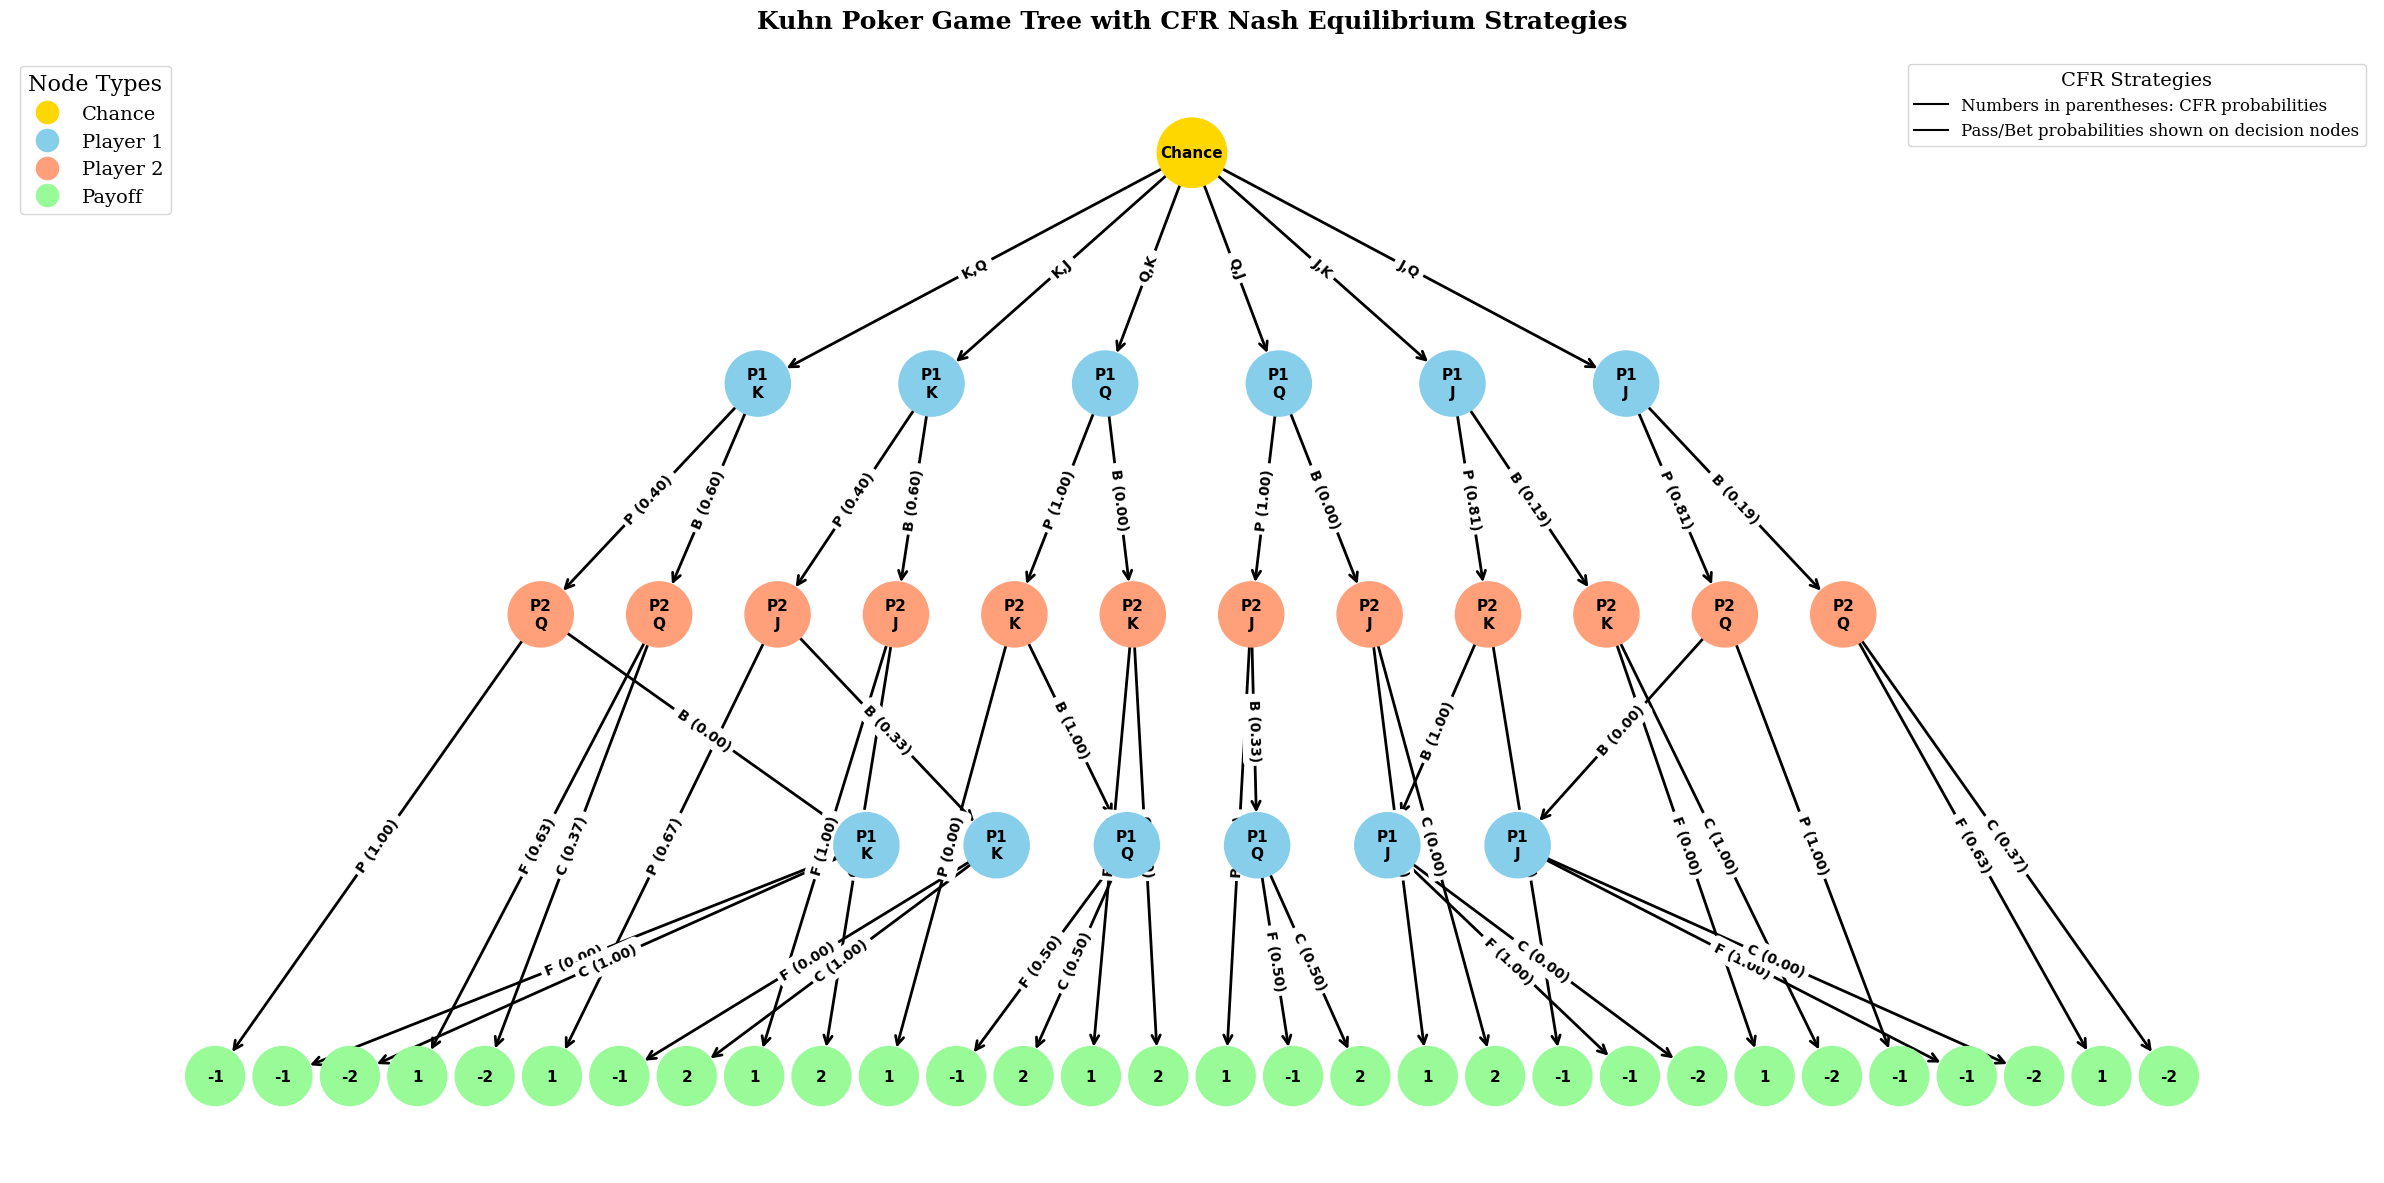

CFR Nash Equilibrium Strategy Analysis:
Player 1, Card K, Initial decision:
  Pass: 0.403
  Bet: 0.597

Player 2, Card Q, After opponent passed:
  Pass: 0.999
  Bet: 0.001

Player 1, Card K, After pass, then opponent bet:
  Fold: 0.000
  Call: 1.000

Player 2, Card Q, After opponent bet:
  Fold: 0.628
  Call: 0.372

Player 1, Card Q, Initial decision:
  Pass: 0.999
  Bet: 0.001

Player 2, Card K, After opponent passed:
  Pass: 0.000
  Bet: 1.000

Player 1, Card Q, After pass, then opponent bet:
  Fold: 0.501
  Call: 0.499

Player 2, Card K, After opponent bet:
  Fold: 0.000
  Call: 1.000

Player 1, Card J, Initial decision:
  Pass: 0.812
  Bet: 0.188

Player 1, Card J, After pass, then opponent bet:
  Fold: 1.000
  Call: 0.000

Player 2, Card J, After opponent passed:
  Pass: 0.669
  Bet: 0.331

Player 2, Card J, After opponent bet:
  Fold: 1.000
  Call: 0.000

Expected Nash Equilibrium Properties:
- King should bet frequently (strong hand)
- Jack should mostly check/call (weak hand)
-

In [7]:
# Test CFR implementation for Kuhn Poker and plot game tree with strategies
import sys
import os

try:
    from kuhn_cfr.cfr import KuhnCFRTrainer
    
    # Create and train CFR solver
    trainer = KuhnCFRTrainer(numPlayers=2, numCards=3)
    strategies, game_values = trainer.solve(numIterations=10000, path=None, verbose=False)
    
    def plot_kuhn_tree_with_cfr_strategies():
        """
        Plot the Kuhn Poker game tree with CFR learned strategies overlaid.
        """
        fig, ax = plt.subplots(1, 1, figsize=(24, 12))
        
        G = nx.DiGraph()
        
        # Root chance node
        G.add_node("ROOT", type="chance", label="Chance")
        
        # Card mappings for display
        card_names = {0: 'J', 1: 'Q', 2: 'K'}
        
        # All 6 possible card deals
        deals = [('K', 'Q'), ('K', 'J'), ('Q', 'K'), ('Q', 'J'), ('J', 'K'), ('J', 'Q')]
        
        # Create nodes and add strategy information
        strategy_dict = {}
        for infoset_key, strategy in strategies.items():
            if isinstance(strategy, np.ndarray):
                player, card, history = infoset_key.split('|')
                strategy_dict[infoset_key] = strategy
        
        for i, (p1_card, p2_card) in enumerate(deals):
            # Player 1's initial decision
            p1_node = f"P1_{p1_card}{p2_card}"
            
            # Get P1's strategy for this card
            p1_card_num = {'J': 0, 'Q': 1, 'K': 2}[p1_card]
            p1_strategy_key = f"0|{p1_card_num}|"
            p1_strategy = strategy_dict.get(p1_strategy_key, [0.5, 0.5])
            
            label = f"P1\n{p1_card}"
            G.add_node(p1_node, type="player1", label=label)
            G.add_edge("ROOT", p1_node, label=f"{p1_card},{p2_card}")
            
            # P1 Passes
            p1_pass = f"P1P_{p1_card}{p2_card}"
            
            # Get P2's strategy after P1 passes
            p2_card_num = {'J': 0, 'Q': 1, 'K': 2}[p2_card]
            p2_strategy_key = f"1|{p2_card_num}|0"
            p2_strategy = strategy_dict.get(p2_strategy_key, [0.5, 0.5])
            
            label = f"P2\n{p2_card}"
            G.add_node(p1_pass, type="player2", label=label)
            G.add_edge(p1_node, p1_pass, label=f"P ({p1_strategy[0]:.2f})")
            
            # P1 Bets
            p1_bet = f"P1B_{p1_card}{p2_card}"
            
            # Get P2's strategy after P1 bets
            p2_bet_strategy_key = f"1|{p2_card_num}|1"
            p2_bet_strategy = strategy_dict.get(p2_bet_strategy_key, [0.5, 0.5])
            
            label = f"P2\n{p2_card}"
            G.add_node(p1_bet, type="player2", label=label)
            G.add_edge(p1_node, p1_bet, label=f"B ({p1_strategy[1]:.2f})")
            
            # Terminal nodes from P1 Pass
            # P1P, P2P - Showdown
            pp_payoff = 1 if p1_card > p2_card else -1
            pp_node = f"PP_{p1_card}{p2_card}"
            G.add_node(pp_node, type="terminal", label=f"{pp_payoff}")
            G.add_edge(p1_pass, pp_node, label=f"P ({p2_strategy[0]:.2f})")
            
            # P1P, P2B - P1 decides again
            pb_node = f"PB_{p1_card}{p2_card}"
            
            # Get P1's second strategy after P2 bets
            p1_second_strategy_key = f"0|{p1_card_num}|0,1"
            p1_second_strategy = strategy_dict.get(p1_second_strategy_key, [0.5, 0.5])
            
            label = f"P1\n{p1_card}"
            G.add_node(pb_node, type="player1", label=label)
            G.add_edge(p1_pass, pb_node, label=f"B ({p2_strategy[1]:.2f})")
            
            # From P1P, P2B
            # P1 Folds
            pbf_node = f"PBF_{p1_card}{p2_card}"
            G.add_node(pbf_node, type="terminal", label="-1")
            G.add_edge(pb_node, pbf_node, label=f"F ({p1_second_strategy[0]:.2f})")
            
            # P1 Calls
            pbc_payoff = 2 if p1_card > p2_card else -2
            pbc_node = f"PBC_{p1_card}{p2_card}"
            G.add_node(pbc_node, type="terminal", label=f"{pbc_payoff}")
            G.add_edge(pb_node, pbc_node, label=f"C ({p1_second_strategy[1]:.2f})")
            
            # Terminal nodes from P1 Bet
            # P2 Folds
            bf_node = f"BF_{p1_card}{p2_card}"
            G.add_node(bf_node, type="terminal", label="1")
            G.add_edge(p1_bet, bf_node, label=f"F ({p2_bet_strategy[0]:.2f})")
            
            # P2 Calls
            bc_payoff = 2 if p1_card > p2_card else -2
            bc_node = f"BC_{p1_card}{p2_card}"
            G.add_node(bc_node, type="terminal", label=f"{bc_payoff}")
            G.add_edge(p1_bet, bc_node, label=f"C ({p2_bet_strategy[1]:.2f})")
        
        # Create hierarchical layout (same as before)
        levels = {}
        for node in G.nodes():
            if node == "ROOT":
                levels[node] = 0
            elif node.startswith("P1_") and len(node.split("_")[1]) == 2:
                levels[node] = 1
            elif node.startswith("P1P_") or node.startswith("P1B_"):
                levels[node] = 2
            elif node.startswith("PB_"):
                levels[node] = 3
            else:  # Terminal nodes
                levels[node] = 4
        
        # Manual positioning for better layout
        pos = {}
        level_width = {0: 1, 1: 8, 2: 12, 3: 6, 4: 18}
        level_nodes = {i: [n for n, l in levels.items() if l == i] for i in range(5)}
        
        for level, nodes in level_nodes.items():
            y = 4 - level * 1.0  # More vertical spacing for strategy text
            if len(nodes) == 1:
                pos[nodes[0]] = (0, y)
            else:
                x_positions = np.linspace(-level_width[level], level_width[level], len(nodes))
                for i, node in enumerate(nodes):
                    pos[node] = (x_positions[i], y)
        
        # Define colors and sizes
        node_colors = []
        node_sizes = []
        for node in G.nodes():
            node_type = G.nodes[node].get('type', 'unknown')
            if node_type == 'chance':
                node_colors.append('#FFD700')  # Gold
                node_sizes.append(2500)
            elif node_type == 'player1':
                node_colors.append('#87CEEB')  # Sky blue
                node_sizes.append(2200)
            elif node_type == 'player2':
                node_colors.append('#FFA07A')  # Light salmon
                node_sizes.append(2200)
            elif node_type == 'terminal':
                node_colors.append('#98FB98')  # Pale green
                node_sizes.append(1800)
            else:
                node_colors.append('gray')
                node_sizes.append(1500)
        
        # Draw the graph
        nx.draw(G, pos,
                node_color=node_colors,
                node_size=node_sizes,
                with_labels=False,
                arrows=True,
                edge_color='black',
                width=2,
                arrowsize=15,
                arrowstyle='->')
        
        # Add node labels
        labels = {node: G.nodes[node].get('label', node) for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=11, font_weight='bold')
        
        # Add edge labels
        edge_labels = {edge: G.edges[edge].get('label', '') for edge in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10, font_weight='bold')
        
        # Add legends
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFD700', markersize=18, label='Chance'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#87CEEB', markersize=18, label='Player 1'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFA07A', markersize=18, label='Player 2'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#98FB98', markersize=18, label='Payoff')
        ]
        legend1 = plt.legend(handles=legend_elements, loc='upper left', fontsize=14, title='Node Types', title_fontsize=16)
        plt.gca().add_artist(legend1)
        
        # Add strategy explanation
        strategy_legend = [
            plt.Line2D([0], [0], color='black', label='Numbers in parentheses: CFR probabilities'),
            plt.Line2D([0], [0], color='black', label='Pass/Bet probabilities shown on decision nodes'),
        ]
        plt.legend(handles=strategy_legend, loc='upper right', fontsize=12, title='CFR Strategies', title_fontsize=14)
        
        ax.set_title("Kuhn Poker Game Tree with CFR Nash Equilibrium Strategies", fontsize=18, fontweight='bold', pad=20)
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Plot the tree with strategies
    plot_kuhn_tree_with_cfr_strategies()
    
    # Display key strategy insights
    print("CFR Nash Equilibrium Strategy Analysis:")
    print("=" * 60)
    
    card_names = {0: 'J', 1: 'Q', 2: 'K'}
    for infoset_key, strategy in strategies.items():
        if isinstance(strategy, np.ndarray):
            player, card, history = infoset_key.split('|')
            card_name = card_names[int(card)]
            player_name = f"Player {int(player) + 1}"
            
            if history == '':
                context = "Initial decision"
                actions = ['Pass', 'Bet']
            elif history == '0':
                context = "After opponent passed"
                actions = ['Pass', 'Bet']
            elif history == '1':
                context = "After opponent bet"
                actions = ['Fold', 'Call']
            elif history == '0,1':
                context = "After pass, then opponent bet"
                actions = ['Fold', 'Call']
            else:
                continue
                
            print(f"{player_name}, Card {card_name}, {context}:")
            for i, (action, prob) in enumerate(zip(actions, strategy)):
                print(f"  {action}: {prob:.3f}")
            print()
    
    print("Expected Nash Equilibrium Properties:")
    print("- King should bet frequently (strong hand)")
    print("- Jack should mostly check/call (weak hand)")
    print("- Queen should use mixed strategies (medium hand)")
    print("- Theoretical game value for Player 1: -1/18 ≈ -0.0556")
    
except ImportError as e:
    print(f"Could not import CFR module: {e}")
    print("Make sure the cfr.py file is in the kuhn_cfr directory")

In [10]:
def plot_game_values(game_values):
    """
    Plot the game values over iterations.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(game_values, label='Game Value', color='blue')
    plt.xlabel('Iteration', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.hlines(0, 0, len(game_values), colors='green', linestyles='--', label='zero')
    plt.hlines(-1/18, 0, len(game_values), colors='red', linestyles='--', 
                label='expected game value')
    plt.tight_layout()
    plt.show()

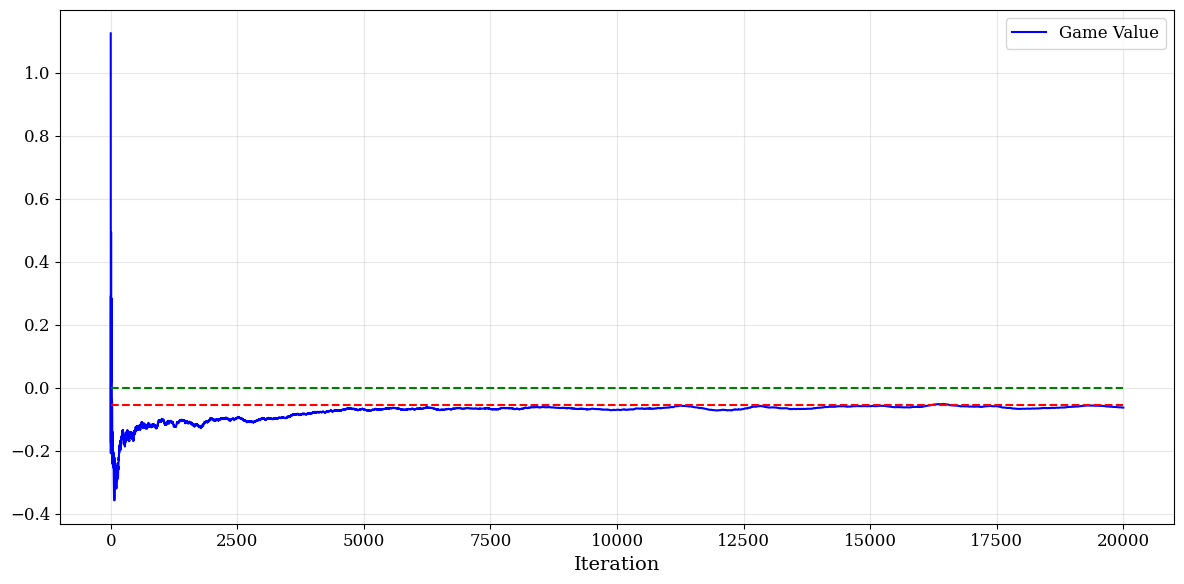

In [11]:
plot_game_values(game_values)

In [ ]:
# Solve Kuhn Poker using Linear Programming and interpret strategies
import sys
import os

try:
    from kuhn_lp.solve import solve_kuhn
    
    # Solve using LP
    result = solve_kuhn()
    
    def interpret_kuhn_lp_strategies(result):
        """
        Properly interpret the LP-solved Kuhn poker strategies.
        The strategy vectors correspond to probability distributions over pure strategies.
        """
        if result is None:
            print("No solution to interpret")
            return
            
        print("\n" + "="*70)
        print("KUHN POKER LINEAR PROGRAMMING STRATEGY INTERPRETATION")
        print("="*70)
        
        # Load or define the pure strategy mapping
        # For Kuhn poker, pure strategies are sequences of actions at each information set
        
        # Player 1 has information sets: [Card J initial], [Card Q initial], [Card K initial], 
        #                                [Card J after P2 bet], [Card Q after P2 bet], [Card K after P2 bet]
        # Each information set has 2 actions: Pass/Fold (0) or Bet/Call (1)
        
        p1_info_sets = [
            "Jack - Initial decision",
            "Queen - Initial decision", 
            "King - Initial decision",
            "Jack - After opponent bet (P2 bet after P1 pass)",
            "Queen - After opponent bet (P2 bet after P1 pass)",
            "King - After opponent bet (P2 bet after P1 pass)"
        ]
        
        p2_info_sets = [
            "Jack - After P1 passed",
            "Queen - After P1 passed",
            "King - After P1 passed", 
            "Jack - After P1 bet",
            "Queen - After P1 bet",
            "King - After P1 bet"
        ]
        
        p1_strategy = result['player1_strategy']
        p2_strategy = result['player2_strategy']
        game_value = result['game_value']
        
        print(f"Game Value: {game_value:.6f}")
        print("(Negative value means Player 2 has advantage, which is expected)")
        
        # The strategy vectors represent probability distributions over pure strategies
        # Each pure strategy is a complete plan for all information sets
        
        print(f"\nPlayer 1 Mixed Strategy Distribution:")
        print(f"Strategy vector has {len(p1_strategy)} components (pure strategies)")
        
        significant_strategies = []
        for i, prob in enumerate(p1_strategy):
            if prob > 0.001:  # Only show strategies with non-negligible probability
                significant_strategies.append((i, prob))
                print(f"  Pure Strategy {i}: probability {prob:.4f}")
        
        print(f"\nPlayer 2 Mixed Strategy Distribution:")
        print(f"Strategy vector has {len(p2_strategy)} components (pure strategies)")
        
        for j, prob in enumerate(p2_strategy):
            if prob > 0.001:
                print(f"  Pure Strategy {j}: probability {prob:.4f}")
        
        # To get behavioral strategies (action probabilities at each information set),
        # we need to aggregate the pure strategy probabilities
        print(f"\n" + "="*50)
        print("BEHAVIORAL STRATEGY INTERPRETATION")
        print("="*50)
        
        print("Note: To convert from mixed strategies over pure strategies")
        print("to behavioral strategies (action probabilities at each information set),")
        print("you need the mapping between pure strategies and action sequences.")
        print("\nEach pure strategy specifies:")
        print("- What to do with Jack initially (Pass/Bet)")
        print("- What to do with Queen initially (Pass/Bet)")  
        print("- What to do with King initially (Pass/Bet)")
        print("- What to do with Jack if opponent bets after you pass (Fold/Call)")
        print("- What to do with Queen if opponent bets after you pass (Fold/Call)")
        print("- What to do with King if opponent bets after you pass (Fold/Call)")
        
        print(f"\nComparison with known theoretical result:")
        theoretical_value = -1/18
        print(f"Theoretical game value: {theoretical_value:.6f}")
        print(f"LP computed game value: {game_value:.6f}")
        print(f"Difference: {abs(theoretical_value - game_value):.8f}")
        
        return result
    
    if result:
        interpret_kuhn_lp_strategies(result)
        
        print("\n" + "="*50) 
        print("KEY INSIGHTS FOR STRATEGY INTERPRETATION")
        print("="*50)
        print("1. Mixed strategies: Players randomize over pure strategies")
        print("2. Pure strategy: Complete plan specifying action at every information set")
        print("3. Behavioral strategy: Action probabilities at each information set")  
        print("4. Nash equilibrium: Neither player can improve by changing strategy")
        print("5. Game value ≈ -0.0556: Slight advantage for Player 2 (dealer)")
        
except ImportError as e:
    print(f"Could not import LP solver: {e}")
    print("Make sure the kuhn_lp module is properly set up")
except Exception as e:
    print(f"Error solving LP: {e}")